In [1]:
# Data handling libraries
import pandas as pd
import numpy as np

# ML libraries
import gplearn as gp
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.preprocessing import MinMaxScaler


# DataViz Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data model save
import pickle

In [2]:
# Plot properties and format
plt.rcParams.update({'mathtext.default':'regular'}) # Latex in text
sns.set(context='notebook', font='Times New Roman', font_scale=1, style='ticks')
%matplotlib notebook

In [4]:
# Confirmed cases in the world

cases = {"confirmed_cases" : pd.read_csv('./time_series_19-covid-Confirmed.csv'),
"death_cases" : pd.read_csv('./time_series_19-covid-Deaths.csv'),
"recovered_cases" : pd.read_csv('./time_series_19-covid-Recovered.csv')}

cases['confirmed_cases'].head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,987,988,989,989,989,989,989,989,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,395,396,399,399,399,400,400,410,410,411
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,567,572,573,575,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,293,293,293,293,293,294,294,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91


In [5]:
#Create a dictionary of cases in time
cases_general = {}
cases_words = ['confirmed','death','recovered']

for word in cases_words:
    cases_in_time = {}
    
    # Columns
    non_usable = 4

    # Confirmed cases in the world
    #world = np.array(cases[f'{word}_cases'].sum()[non_usable-2:], dtype=float)
    #cases_in_time['world'] = world    
    # Confirmed cases only in china
    mainland_china = cases[f'{word}_cases'][cases[f'{word}_cases']['Country/Region'] == 'Mainland China']
    cases_in_time[f'{word}_mainland_china'] = np.array(mainland_china.sum()[non_usable:], dtype=float)

    #Confirmed cases in other places but china
    not_china = cases[f'{word}_cases'][cases[f'{word}_cases']['Country/Region'] != 'Mainland China']
    cases_in_time[f'{word}_not_china'] = np.array(not_china.sum()[non_usable-2:], dtype=float)
    
    # Save in the dictionary each of the cases
    cases_general[word] = cases_in_time
data_dataframe = pd.concat([pd.DataFrame(cases_general[key] ) for key in cases_general.keys()], axis=1)
data_dataframe.head()

,confirmed_mainland_china,confirmed_not_china,death_mainland_china,death_not_china,recovered_mainland_china,recovered_not_china
0,547.0,8.0,17.0,0.0,28.0,0.0
1,639.0,14.0,18.0,0.0,30.0,0.0
2,916.0,25.0,26.0,0.0,36.0,0.0
3,1399.0,35.0,42.0,0.0,39.0,0.0
4,2062.0,56.0,56.0,0.0,49.0,3.0


In [6]:
# Change the scale of the data with MinMaxScaler function
scaler = MinMaxScaler()
scaler.fit(data_dataframe)
norm_dataframe = pd.DataFrame(scaler.transform(data_dataframe))
norm_dataframe.columns = [f'norm_{element}' for element in data_dataframe.columns]
norm_dataframe.head()

,norm_confirmed_mainland_china,norm_confirmed_not_china,norm_death_mainland_china,norm_death_not_china,norm_recovered_mainland_china,norm_recovered_not_china
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.001169,0.000888,0.000355,0.0,0.000051,0.000000
2,0.004688,0.002517,0.003194,0.0,0.000204,0.000000
3,0.010825,0.003998,0.008872,0.0,0.000280,0.000000
4,0.019249,0.007107,0.013840,0.0,0.000535,0.005964


In [7]:
# Determine a numerical value for the dates

# We will use the dates in the dataset, to easily identify this, it is possible to use a common
# trait. 
timelapse = [pd.to_datetime(elem) for elem in cases['confirmed_cases'].columns if '/20' in elem]

time_numerical_value = [int(str(timelapse[i] - timelapse[0]).split(' ')[0]) for i in range(len(timelapse))]

# Time from the day Jan/22/20
time_information = pd.DataFrame([timelapse,time_numerical_value]).T
time_information.columns = ['date','numerical_value']
time_information.tail()

,date,numerical_value
34,2020-02-25,34
35,2020-02-26,35
36,2020-02-27,36
37,2020-02-28,37
38,2020-02-29,38


In [8]:
# Create a dataframe with all the information

# All dataframes merged
cases_dataframe = pd.concat([time_information,data_dataframe,norm_dataframe],axis=1)

# Obtain the percentages of death cases and of the recovered cases
# death percentage
cases_dataframe['death_percentage_mainland_china'] = 100*cases_dataframe['death_mainland_china']/cases_dataframe['confirmed_mainland_china']
# recovered percentage
cases_dataframe['recovered_percentage_mainland_china'] = 100*cases_dataframe['recovered_mainland_china']/cases_dataframe['confirmed_mainland_china']

cases_dataframe.head()

,date,numerical_value,confirmed_mainland_china,confirmed_not_china,death_mainland_china,death_not_china,recovered_mainland_china,recovered_not_china,norm_confirmed_mainland_china,norm_confirmed_not_china,norm_death_mainland_china,norm_death_not_china,norm_recovered_mainland_china,norm_recovered_not_china,death_percentage_mainland_china,recovered_percentage_mainland_china
0,2020-01-22,0,547.0,8.0,17.0,0.0,28.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.107861,5.118830
1,2020-01-23,1,639.0,14.0,18.0,0.0,30.0,0.0,0.001169,0.000888,0.000355,0.0,0.000051,0.000000,2.816901,4.694836
2,2020-01-24,2,916.0,25.0,26.0,0.0,36.0,0.0,0.004688,0.002517,0.003194,0.0,0.000204,0.000000,2.838428,3.930131
3,2020-01-25,3,1399.0,35.0,42.0,0.0,39.0,0.0,0.010825,0.003998,0.008872,0.0,0.000280,0.000000,3.002144,2.787706
4,2020-01-26,4,2062.0,56.0,56.0,0.0,49.0,3.0,0.019249,0.007107,0.013840,0.0,0.000535,0.005964,2.715810,2.376334


<IPython.core.display.Javascript object>


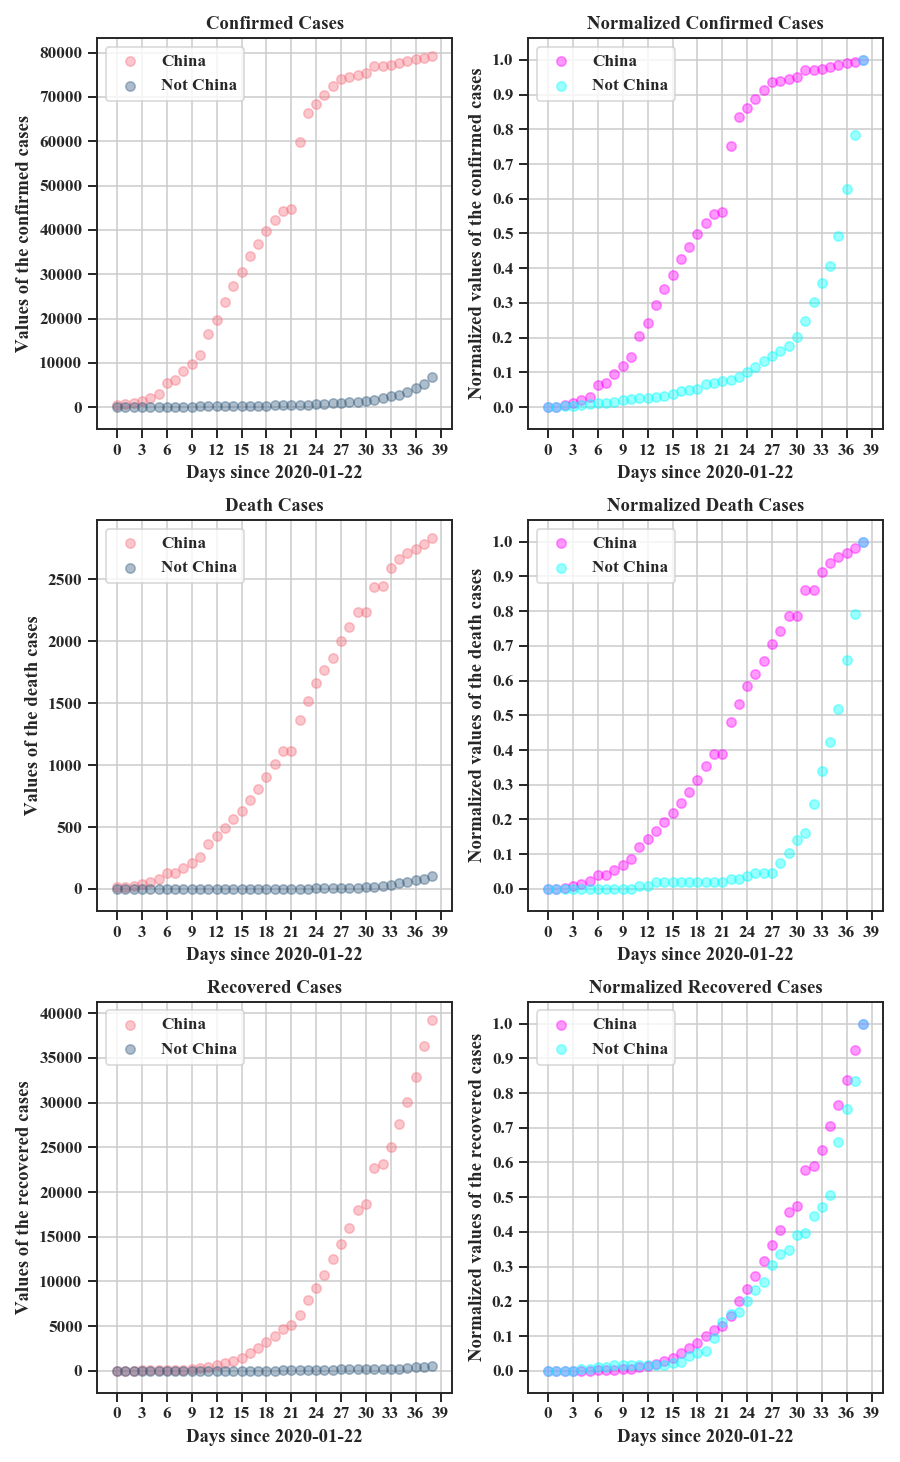

In [9]:
# Plots of the normalized traits and their importances

fig = plt.figure(figsize=(8,13))

# Some parameters for the plotting format
xtext = f'Days since {str(cases_dataframe.date[0]).split(" ")[0]}'
spacing = np.arange(0,int(max(cases_dataframe['numerical_value']))+2,step=3)
transparent = .4

# Plot the world cases. 
for i,word in enumerate(cases_words):
    # All the cases (untransformed data)
    plt.subplot(len(cases_words),2,2*i+1)
    
    # Scatter plot for mainland china
    plt.scatter(cases_dataframe['numerical_value'], 
         cases_dataframe[f'{word}_mainland_china'],
         color = '#F67280', label = 'China', alpha = transparent
           )
    # Scatter plot for the rest of the world
    plt.scatter(cases_dataframe['numerical_value'], 
         cases_dataframe[f'{word}_not_china'],
         color = '#355C7D', label = 'Not China', alpha = transparent
           )
    
    # Writen parameters of the plot
    plt.title(f'{word.capitalize()} Cases')
    plt.ylabel(f'Values of the {word} cases')
    plt.xlabel(xtext)
    
    # Grid and legend
    plt.xticks(spacing)
    plt.grid()
    plt.legend()

    
    # Normalized cases
    plt.subplot(len(cases_words),2,2*i+2)
    
    #Scatter plot for normalized mainland china cases
    plt.scatter(cases_dataframe['numerical_value'], 
         cases_dataframe[f'norm_{word}_mainland_china'],
         color = 'magenta', label = 'China', alpha = transparent
           )
    
    #Scatter plot for the normalized data of the rest of the world cases
    plt.scatter(cases_dataframe['numerical_value'], 
         cases_dataframe[f'norm_{word}_not_china'],
         color = 'cyan', label = 'Not China', alpha = transparent
           )
    
    # Written parameters of the plot
    plt.title(f'Normalized {word.capitalize()} Cases')
    plt.ylabel(f'Normalized values of the {word} cases')
    plt.xlabel(xtext)
    
    # Grid and legends
    plt.yticks(np.arange(0,1.1,step=.1))
    plt.xticks(spacing)
    plt.grid()
    plt.legend()

# Automatically modify the position of the plots
plt.tight_layout()

In [10]:
# Non dependeant variable for regressions (numerical value of the date).
X0_DATA = np.array(cases_dataframe['numerical_value'],dtype=float).reshape(-1,1)

In [11]:
# Use the Symbolic Regressor for normalized data

# Define an exponential operator to create a symbolic function
def _protected_exponent(x1):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x1) < 100, np.exp(x1), 0.)
    
# Create a compatible function with the list for the function_set
exponential = make_function(function=_protected_exponent, name='exp', arity=1)

f_list = ['add','sub','mul', exponential]
# Create a Symbolic Regressor object (estimator genetic predictor)
est_gp =  [SymbolicRegressor(population_size = 60000,
                           generations = 30,
                           stopping_criteria = 0.001,
                           function_set = f_list,
                           p_crossover = 0.70,
                           p_subtree_mutation = 0.20,
                           max_samples = 0.97,
                           verbose = 1,
                           parsimony_coefficient = 0.001) for i in range(len(cases_words))]
# Fit with the data
for i in range(len(cases_words)):
    est_gp[i].fit(X0_DATA , cases_dataframe[f'norm_{cases_words[i]}_mainland_china'])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    28.06     6.51565e+132       13        0.0821262        0.0759283     24.67m
   1    15.25      2.73967e+95       13        0.0791623        0.0862194     17.83m
   2    14.90      1.95608e+76       54        0.0685016        0.0503123     17.10m
   3    24.97      6.37791e+72       24        0.0533069        0.0509577     18.54m
   4    21.91      2.89326e+79       34        0.0363808        0.0331382     17.26m
   5    17.88      1.14414e+64       41        0.0282302        0.0568943     15.37m
   6    14.48      1.13415e+68       25        0.0254576         0.092025     14.54m
   7    15.18      9.12141e+57       40        0.0252472      0.000274457     13.93m
   8    20.39      2.60368e+52       25        0.0202971         0.164337  

  28    14.89      1.40202e+93       15       0.00773194        0.0251659     35.47s
  29    14.84        3.402e+73       15       0.00758151        0.0279489      0.00s


In [12]:
# Show the results
#est_gp = []
#for i in range(3):
#    with open(f'Covid_19_gp_model_{cases_words[i]}.pkl', 'rb') as f:
#       est_gp.append(pickle.load(f))
#est_gp
for i in range(len(est_gp)):
    print(est_gp[i]._program)

exp(mul(sub(mul(mul(X0, -0.070), X0), exp(0.304)), exp(add(exp(0.451), mul(-0.300, X0)))))
mul(mul(0.027, X0), exp(mul(mul(-0.937, X0), exp(mul(-0.211, X0)))))
mul(mul(0.060, add(add(mul(X0, mul(0.036, X0)), -0.951), -0.951)), mul(X0, 0.009))


In [29]:
for i in range(len(est_gp)):
    delattr(est_gp[i],'_programs')
    with open(f'Covid_19_gp_model_{cases_words[i]}_6.pkl', 'wb') as f:    
        pickle.dump(est_gp[i],f)

In [15]:
days = 40

In [16]:
# Use polinomial regression to have another model for comparision
def polyfits(x, y, order, array_len):
    global days
    # x are the values for the polinomial fitting
    # order gives the order of the polinomial
    # array_len gives the vector output size
    
    # Generate the polinomial regression coefficients of the cases in china
    value = np.polyfit(x, y , order)
    
    # Initialize a vector that will hold the answer 
    ans = np.zeros(array_len)
    
    # Create a linear spacing for the answer 
    arr = np.linspace(0,days,array_len)
        
    # Actualize the answer vector with the coefficients and the array
    for v in range(order):
        ans += value[v]*arr**(order-v)
        
    # Return the x-array, the answer and the coefficients
    return arr, ans, [value]

In [17]:
# Predictions for the regressions
regressions = {}
order = [6,2,3]

# Scaling coefficients
scaling_coef = {}

for i in range(len(cases_words)):
    py = {}
    coefs = {}
    # Predictions for the polynomial regression
    x_vals, py['y_poly'], coefs[cases_words[i]] = polyfits(X0_DATA.flatten(), 
                                            cases_dataframe[f'norm_{cases_words[i]}_mainland_china'],
                                            order[i],1000)
    regressions[cases_words[i]] = py
    # Retrieve the values for the regressions (rescale the values)
    vals = cases_general[cases_words[i]][f'{cases_words[i]}_mainland_china']
    y_poly_reg = py['y_poly']*(vals.max()-vals.min())+(vals.min())
    regressions[cases_words[i]]['y_poly_scaled'] = y_poly_reg
    
    scaling_coef[cases_words[i]] = [vals.max(),vals.min()]
    # Predictions for the symbolic regression
    regressions[cases_words[i]]['y_symb'] = est_gp[i].predict(x_vals.reshape(-1, 1))
    regressions[cases_words[i]]['y_symb_scaled'] = regressions[cases_words[i]]['y_symb']*(vals.max()-vals.min())+(vals.min())

In [18]:
x_real_vals = np.array(cases_dataframe['numerical_value'])

prediction_values={}
for i in range(len(cases_words)):
    coef_max,coef_min = scaling_coef[cases_words[i]]
    prediction_values[cases_words[i]] = est_gp[i].predict(x_real_vals.reshape(-1,1))*(coef_max-coef_min)+coef_min

In [19]:
# Retrieve texts by including the equations found in the symbolic regression and
# the values obtained from the scaling_coef variables

texts = ['106.74888 x^2 + 325','2.96112 x^2', '0.018017963238x^4 + 25']

In [20]:
days = 40
startdate = time_information.date[0]
enddate = ['-'.join(str(pd.to_datetime(startdate) + pd.DateOffset(days=i)).split(' ')[0].split('-')[1:]) for i in range(days+2)]

<IPython.core.display.Javascript object>


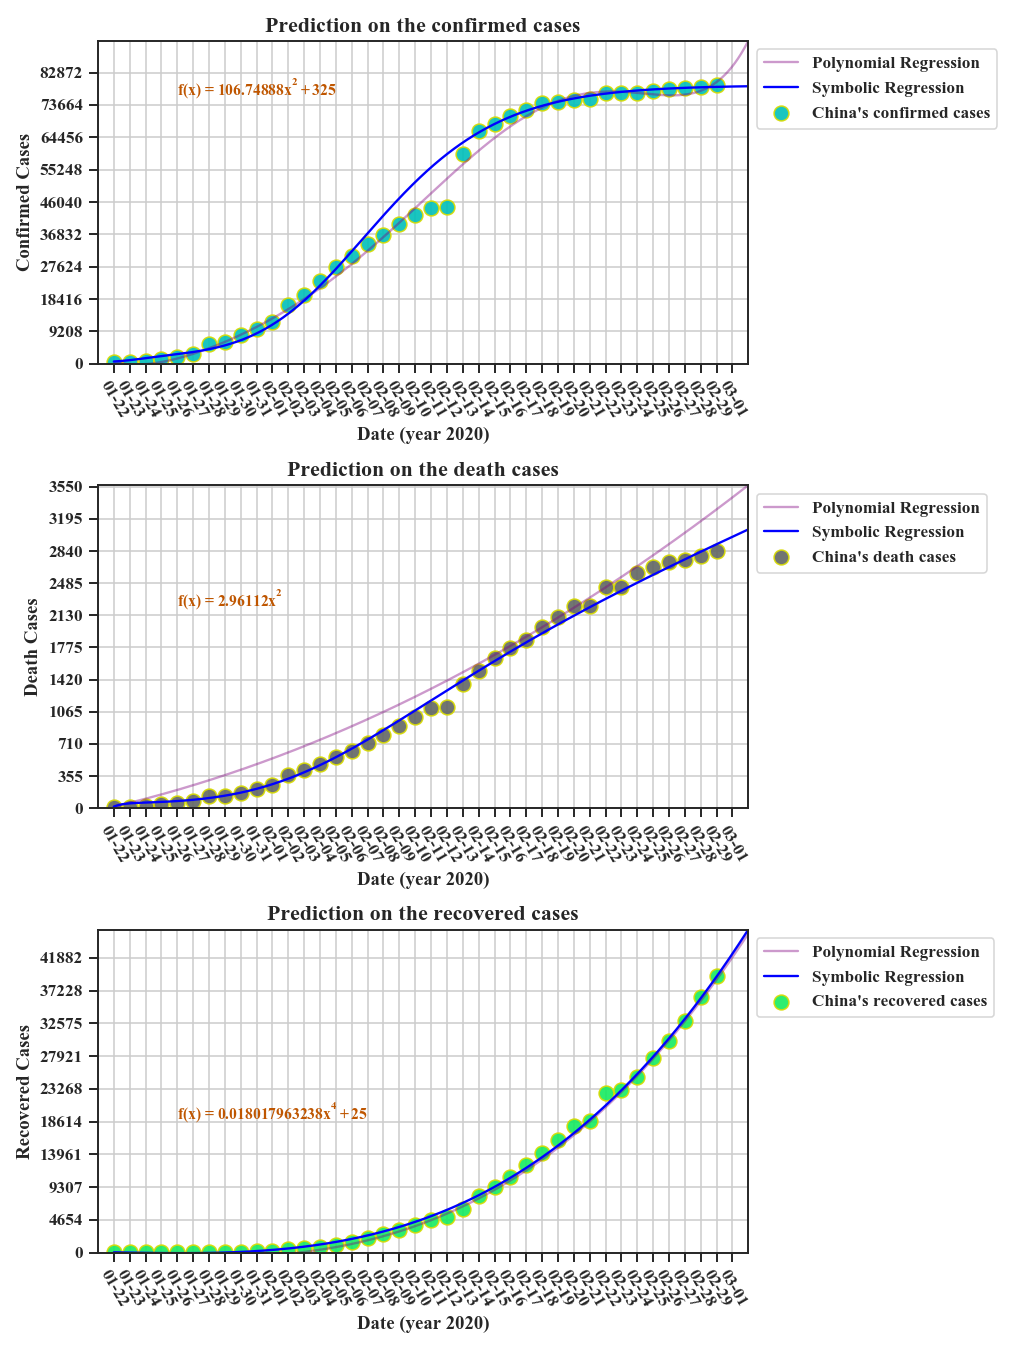

In [21]:
colors = ['#00bfb9', '#626663', '#15eb60']
plt.figure(figsize=(9,12))

for i in range(len(cases_words)):
    # Distinct Cases
    plt.subplot(len(cases_words),1,i+1)
    
    # Plot an individual case
    y_poly = regressions[cases_words[i]]['y_poly_scaled']
    y_symb = regressions[cases_words[i]]['y_symb_scaled']
    
    plt.plot(x_vals, y_poly, color='purple', label = 'Polynomial Regression', alpha = .4)
    plt.plot(x_vals, y_symb, color= 'blue', label = 'Symbolic Regression')
    
    plt.text(x_vals[len(x_vals)//10], y_symb[3*len(y_symb)//4], s=f"f(x) = ${texts[i]}$", c = '#bf5600' )
    # Plot the real data
    plt.scatter(cases_dataframe['numerical_value'], 
                cases_dataframe[f'{cases_words[i]}_mainland_china'],
                color = colors[i], label = f"China's {cases_words[i]} cases",s=90, alpha=.9,edgecolors="#d8db00")

    # Determine the maximum and minimum values  for the box
    max_val = np.max([np.max(regressions[cases_words[i]]['y_symb_scaled']),
                      np.max(regressions[cases_words[i]]['y_poly_scaled'])])
    min_val = np.min([np.min(regressions[cases_words[i]]['y_symb_scaled']),
                      np.min(regressions[cases_words[i]]['y_poly_scaled'])])
    
    # Delimit the window and write the grid
    plt.ylim(0,max_val)
    plt.xlim(-1,days)
    plt.grid()

    
    # Write the ticks for the plot
    plt.xticks([i for i in range(days)], enddate, rotation=-60)
    plt.yticks(np.arange(0,max_val,step=(max_val-min_val)/10))

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Prediction on the {cases_words[i]} cases', fontsize=14)
    
    # Include legend
    plt.legend(loc = "upper left", bbox_to_anchor = (1,1))

plt.tight_layout()

<IPython.core.display.Javascript object>


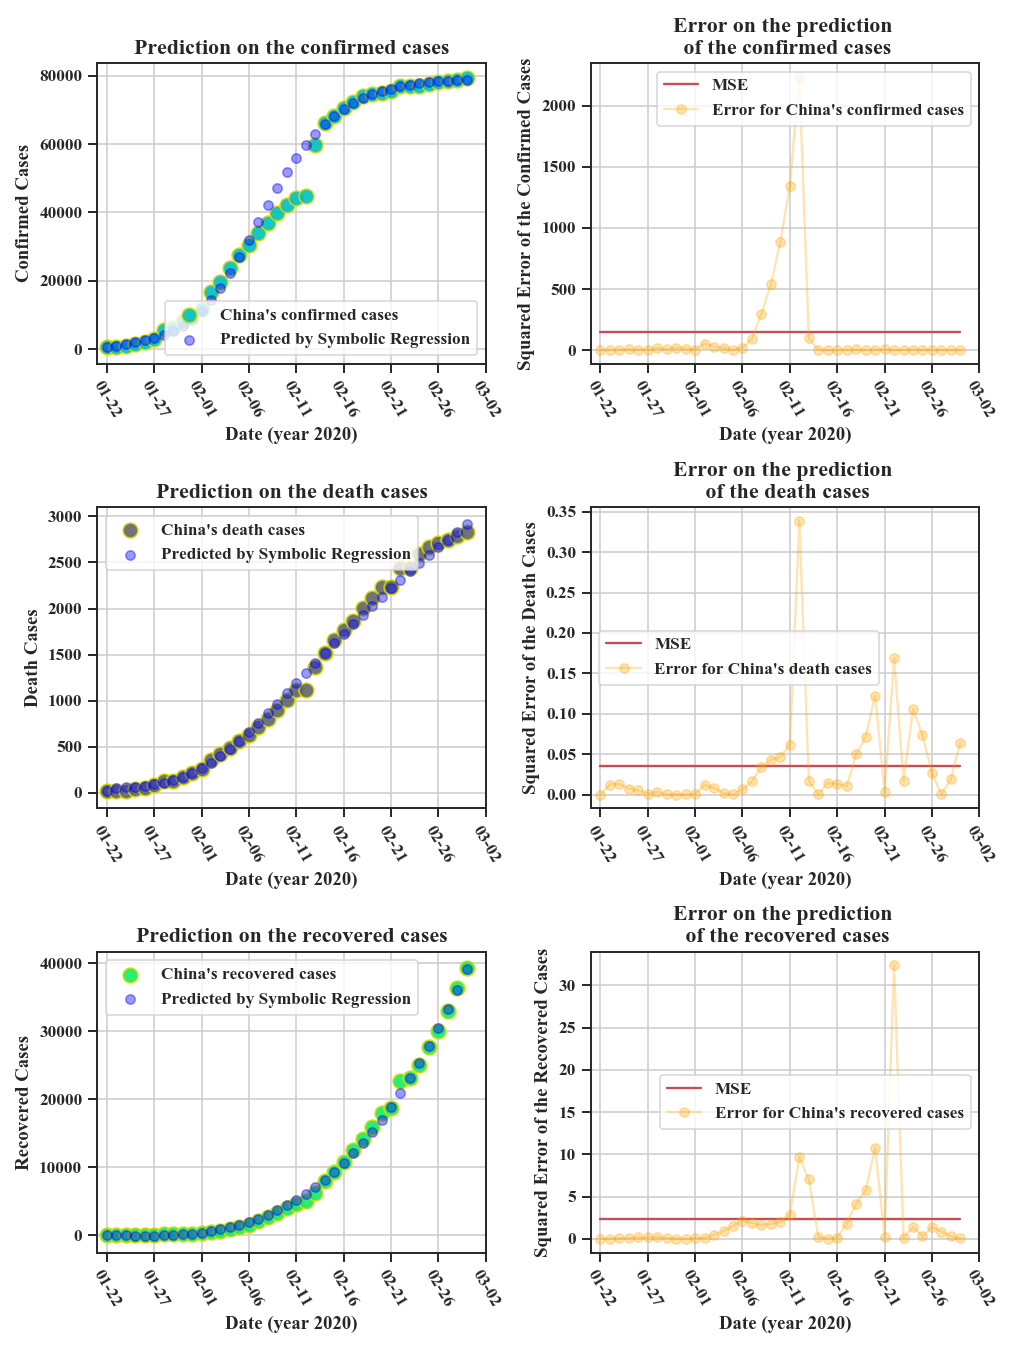

In [22]:
colors = ['#00bfb9', '#626663', '#15eb60']
plt.figure(figsize=(9,12))

for i in range(len(cases_words)):
    # Distinct Cases
    plt.subplot(len(cases_words),2,2*i+1)
    
    # Plot the real data
    plt.scatter(cases_dataframe['numerical_value'], 
                cases_dataframe[f'{cases_words[i]}_mainland_china'],
                color = colors[i], label = f"China's {cases_words[i]} cases",s=90, alpha=.9,edgecolors="#d8db00")

    # Plot the predicted data
    plt.scatter(x_real_vals, prediction_values[cases_words[i]],
                color= 'blue', label = 'Predicted by Symbolic Regression', alpha=.4)

    # Delimit the window and write the grid
    plt.xlim(-1,days)
    plt.grid()
    # Write the ticks for the plot
    day_spam = 5
    plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

    
    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Prediction on the {cases_words[i]} cases', fontsize=14)
    
    # Include legend
    plt.legend()
    
    plt.subplot(len(cases_words),2,2*i+2)
    
    # Plot the error
    squared_error = (prediction_values[cases_words[i]]-cases_dataframe[f'{cases_words[i]}_mainland_china'])**2/100000
    
    plt.plot(x_real_vals, np.mean(squared_error)*np.ones(len(x_real_vals)),c='r', label = 'MSE')

    plt.plot(cases_dataframe['numerical_value'], 
                squared_error,
                color = 'orange', marker = 'o',
                label = f"Error for China's {cases_words[i]} cases", alpha=.3)

    # Delimit the window and write the grid
    plt.xlim(-1,days)
    plt.grid()
    # Write the ticks for the plot
    day_spam = 5
    plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'Squared Error of the {cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Error on the prediction \n of the {cases_words[i]} cases', fontsize=14)
    
    # Include legend
    plt.legend()
    
plt.tight_layout()

<IPython.core.display.Javascript object>


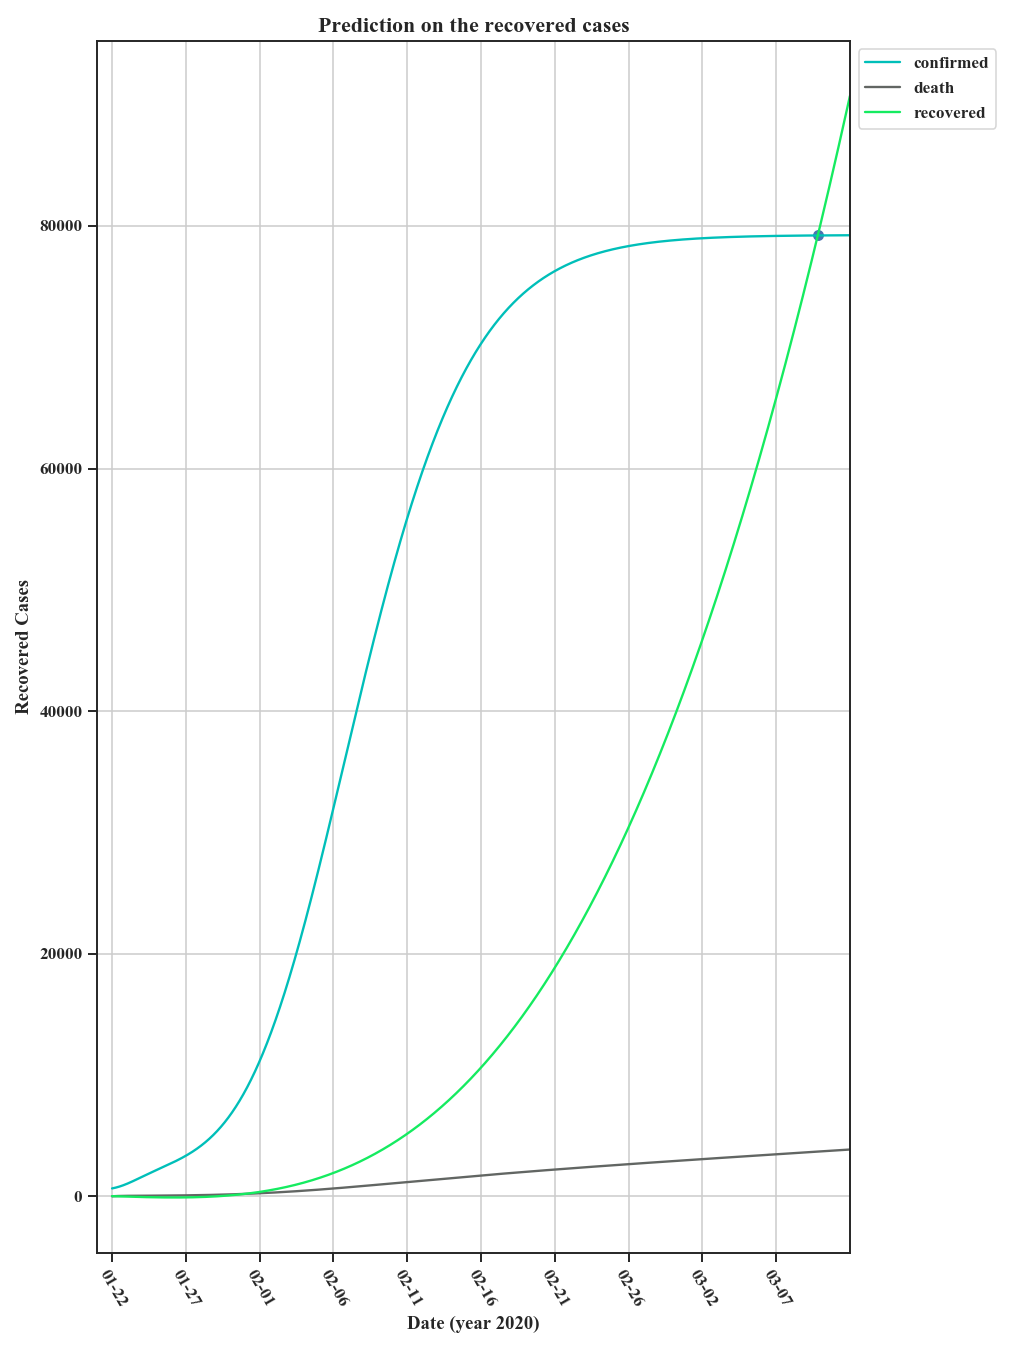

In [23]:
days2 = 50
enddate2 = ['-'.join(str(pd.to_datetime(startdate) + pd.DateOffset(days=i)).split(' ')[0].split('-')[1:]) for i in range(days2+2)]
future_vals = np.linspace(0,days2,100000)


colors = ['#00bfb9', '#626663', '#15eb60']
plt.figure(figsize=(9,12))

future_predictions = {}

equal_value = pd.DataFrame(future_vals.reshape(-1, 1), columns=['x'])
for i in range(len(cases_words)):
    y_max, y_min = scaling_coef[cases_words[i]]
    # Predictions for the symbolic regression
    future_predictions[cases_words[i]] = {}
    future_predictions[cases_words[i]]['y_symb'] = est_gp[i].predict(future_vals.reshape(-1, 1))
    future_predictions[cases_words[i]]['y_symb_scaled'] = future_predictions[cases_words[i]]['y_symb']*(y_max-y_min)+(y_min)
        
    # Plot an individual case    
    #plt.plot(x_vals, y_poly, color='purple', label = 'Polynomial Regression', alpha = .4)
    plt.plot(future_vals, future_predictions[cases_words[i]]['y_symb_scaled'], color= colors[i], label = f'{cases_words[i]}')

    equal_value[cases_words[i]] = future_predictions[cases_words[i]]['y_symb_scaled']
    
    # Delimit the window and write the grid
    plt.xlim(-1,days2)
    plt.grid()

    
    # Write the ticks for the plot
    day_spam = 5
    plt.xticks([day_spam*i for i in range(len(enddate2)//day_spam)], [enddate2[day_spam*i] for i in range(len(enddate2)//day_spam)], rotation=-60)


    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Prediction on the {cases_words[i]} cases', fontsize=14)
    
    # Include legend
    plt.legend(loc = "upper left", bbox_to_anchor = (1,1))
equal_value['difference'] = abs(equal_value['confirmed']-equal_value['recovered'])

plt.tight_layout()
equal_value_coordinate = equal_value[equal_value['difference'] == equal_value['difference'].min()]#[equal_value.difference<10]
plt.scatter(equal_value_coordinate.x,equal_value_coordinate.recovered)

<IPython.core.display.Javascript object>


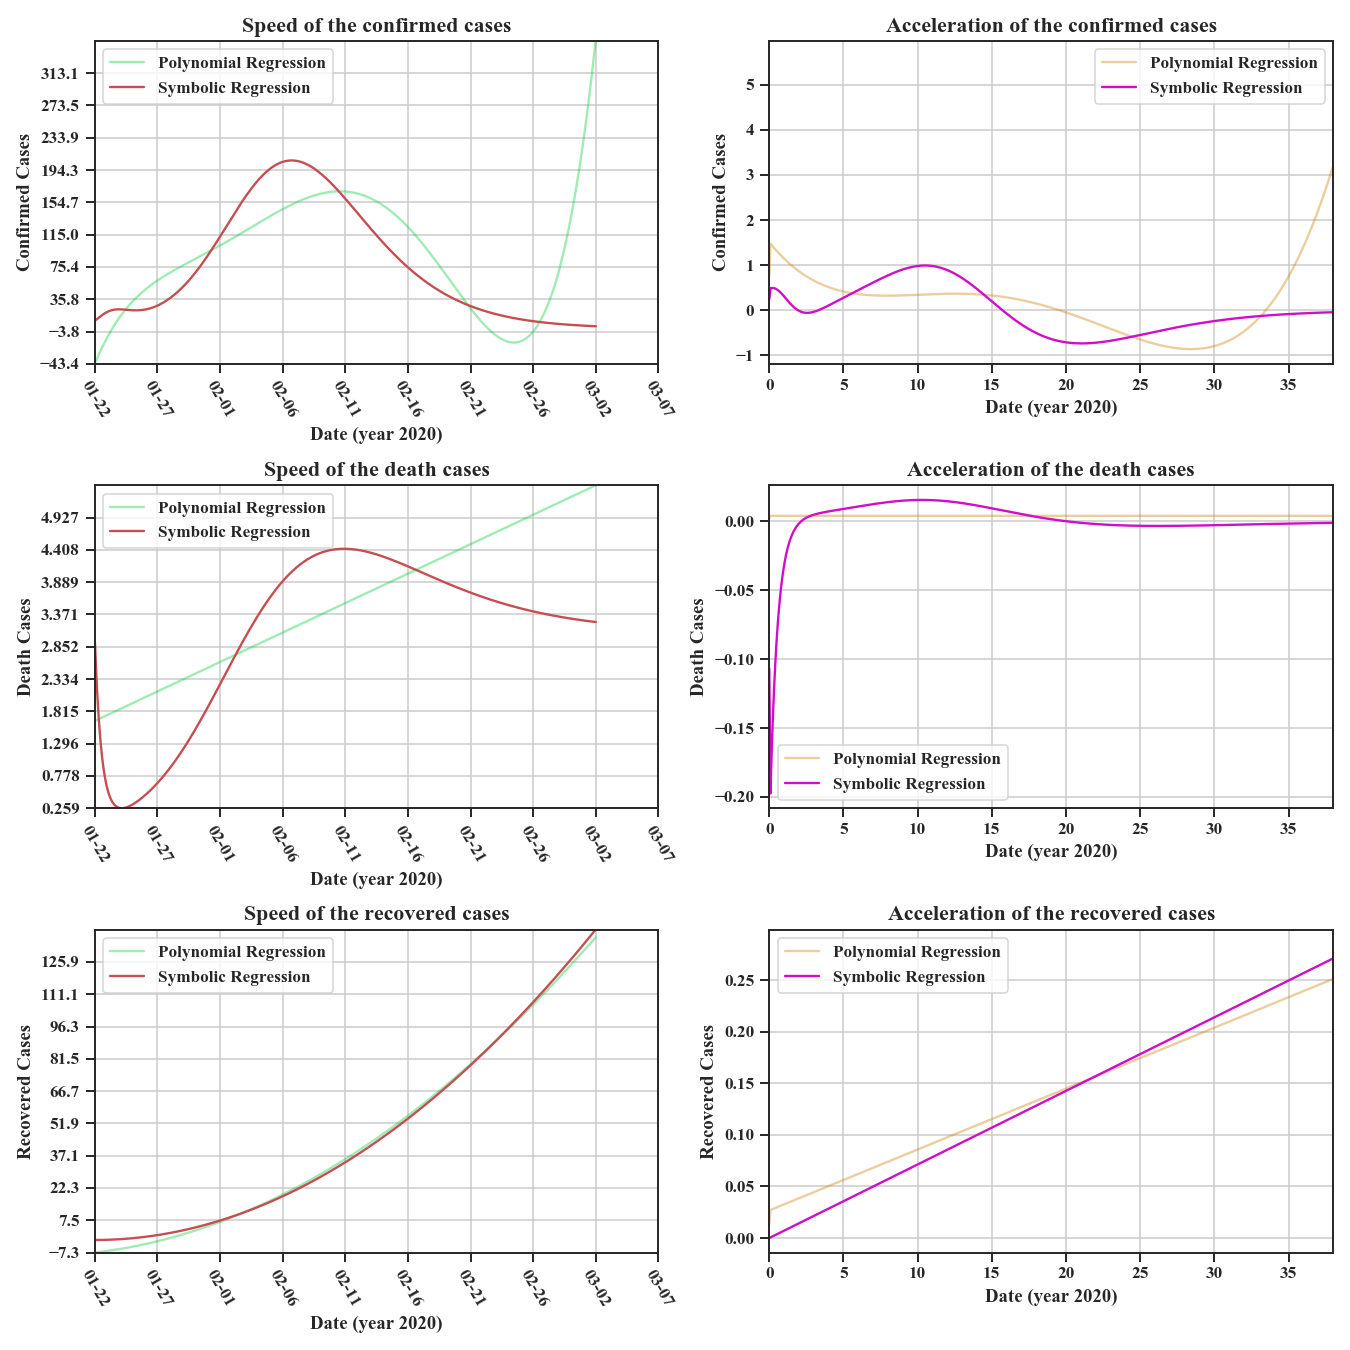

In [24]:
plt.figure(figsize=(12,12))

for i in range(len(cases_words)):
    
    # Velocity plots
    plt.subplot(len(cases_words),2,2*i+1)
    
    # Determine the velocity as the gradiento of the equation
    speed_poly = np.gradient(regressions[cases_words[i]]['y_poly_scaled'])
    speed_symb = np.gradient(regressions[cases_words[i]]['y_symb_scaled'])
    # Plot the values
    plt.plot(x_vals,speed_poly , color='#0dd141', label = 'Polynomial Regression', alpha = .4)
    plt.plot(x_vals,speed_symb , color='r', label = 'Symbolic Regression')
        
    # Determine maximum and minimum values for the window
    max_val_speed = np.max([np.max(speed_poly),
                      np.max(speed_symb)])
    min_val_speed = np.min([np.min(speed_poly),
                      np.min(speed_symb)])
    
    # Delimit the box
    plt.ylim(min_val_speed,max_val_speed)
    plt.xlim(0,days)

    # Use a written for x and y ticks and grid
    day_spam = 5
    plt.xticks([day_spam*i for i in range(len(enddate2)//day_spam)], [enddate2[day_spam*i] for i in range(len(enddate2)//day_spam)], rotation=-60)
    plt.yticks(np.arange(min_val_speed,max_val_speed,step=(max_val_speed-min_val_speed)/10))
    plt.grid()

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')    
    plt.title(f'Speed of the {cases_words[i]} cases', fontsize=14)
    
    # Legend
    plt.legend()

    # Acceleration plots
    plt.subplot(len(cases_words),2,2*i+2)
    
    # Determine the acceleration as the gradiento of the velocity
    acc_poly = np.gradient(speed_poly)
    acc_symb = np.gradient(speed_symb)
    
    #Plot the values
    plt.plot(x_vals,acc_poly , color='#d1830d', label = 'Polynomial Regression', alpha = .4)
    plt.plot(x_vals,acc_symb , color= '#d10dc7', label = 'Symbolic Regression')

    # Delimit the box
    plt.xlim(0,days-2)

    # Use a written for x and y ticks and grid
    day_spam = 2
    #plt.xticks([day_spam*i for i in range(len(enddate)//day_spam)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam)], rotation=-60)
    plt.grid()

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Acceleration of the {cases_words[i]} cases', fontsize=14)
    
    # Legend
    plt.legend()
    
plt.tight_layout()

<IPython.core.display.Javascript object>


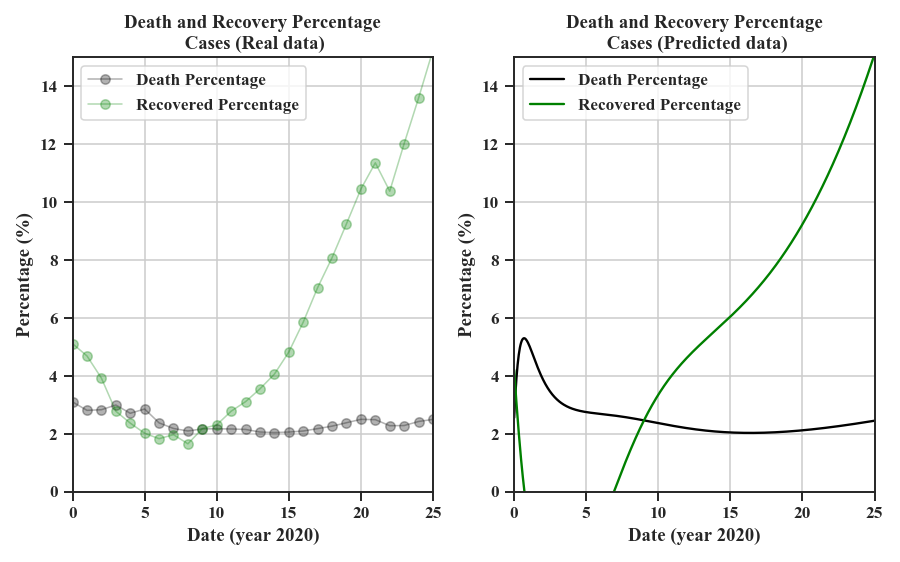

In [25]:
# Determine the death  and recovered percentage functions
death_percentage = 100*regressions['death']['y_symb_scaled']/regressions['confirmed']['y_symb_scaled']
recovered_percentage = 100*regressions['recovered']['y_symb_scaled']/regressions['confirmed']['y_symb_scaled']

plt.figure(figsize=(8,5))

# Real data
plt.subplot(121)

plt.plot(cases_dataframe['numerical_value'], cases_dataframe['death_percentage_mainland_china'],
         color = 'black', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')
plt.plot(cases_dataframe['numerical_value'], cases_dataframe['recovered_percentage_mainland_china'],
         color = 'green', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

#plt.xticks([5*i for i in range(5+1)], [enddate[5*i] for i in range(5+1)], rotation=-60)
plt.xlim(0,25)
plt.ylim(0,15)
plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage\n Cases (Real data)')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')


# Predicted data
plt.subplot(122)

plt.plot(x_vals, death_percentage, color ='black',label = 'Death Percentage')
plt.plot(x_vals, recovered_percentage, color = 'green', label = 'Recovered Percentage')

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.xlim(0,25)
plt.ylim(0,15)
plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage\n Cases (Predicted data)')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')

plt.tight_layout()

<IPython.core.display.Javascript object>


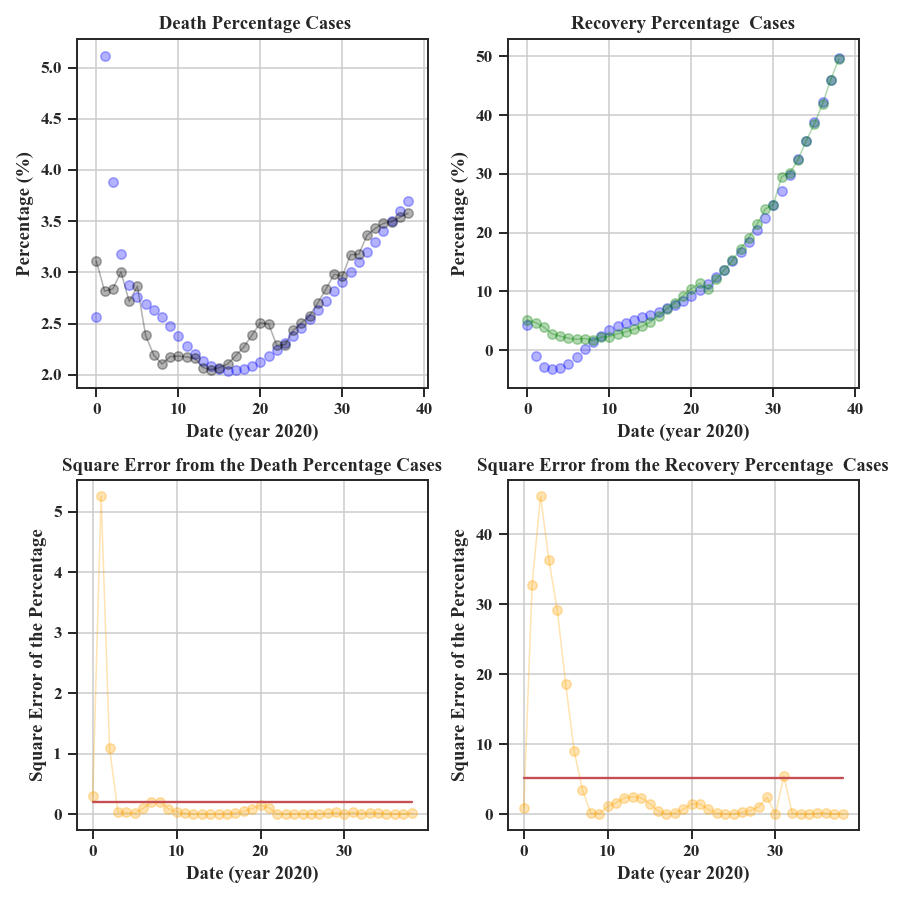

In [26]:
plt.figure(figsize = (8,8))

plt.subplot(221)

plt.plot(x_real_vals, cases_dataframe['death_percentage_mainland_china'],
         color = 'black', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')

y_death_predictions = 100*(prediction_values['death']/prediction_values['confirmed'])

plt.scatter(x_real_vals, y_death_predictions, color = 'blue',alpha=.3)

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title(' Death Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')
plt.grid()


plt.subplot(222)

plt.plot(x_real_vals, cases_dataframe['recovered_percentage_mainland_china'],
         color = 'green', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

y_recovered_predictions = 100*(prediction_values['recovered']/prediction_values['confirmed'])

plt.scatter(x_real_vals, y_recovered_predictions, color = 'blue',alpha=.3)

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Recovery Percentage  Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')
plt.grid()
plt.tight_layout()



plt.subplot(223)
squared_error_death = (cases_dataframe['death_percentage_mainland_china']-y_death_predictions)**2
plt.plot(x_real_vals, squared_error_death,
         color = 'orange', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')
plt.plot(x_real_vals, np.mean(squared_error_death)*np.ones(len(x_real_vals)),c='r')


day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Square Error from the Death Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Square Error of the Percentage')
plt.grid()


plt.subplot(224)
squared_error_recovered = (cases_dataframe['recovered_percentage_mainland_china']-y_recovered_predictions)**2
plt.plot(x_real_vals, squared_error_recovered ,
         color = 'orange', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

plt.plot(x_real_vals, np.mean(squared_error_recovered)*np.ones(len(x_real_vals)),c='r')

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Square Error from the Recovery Percentage  Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Square Error of the Percentage')
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


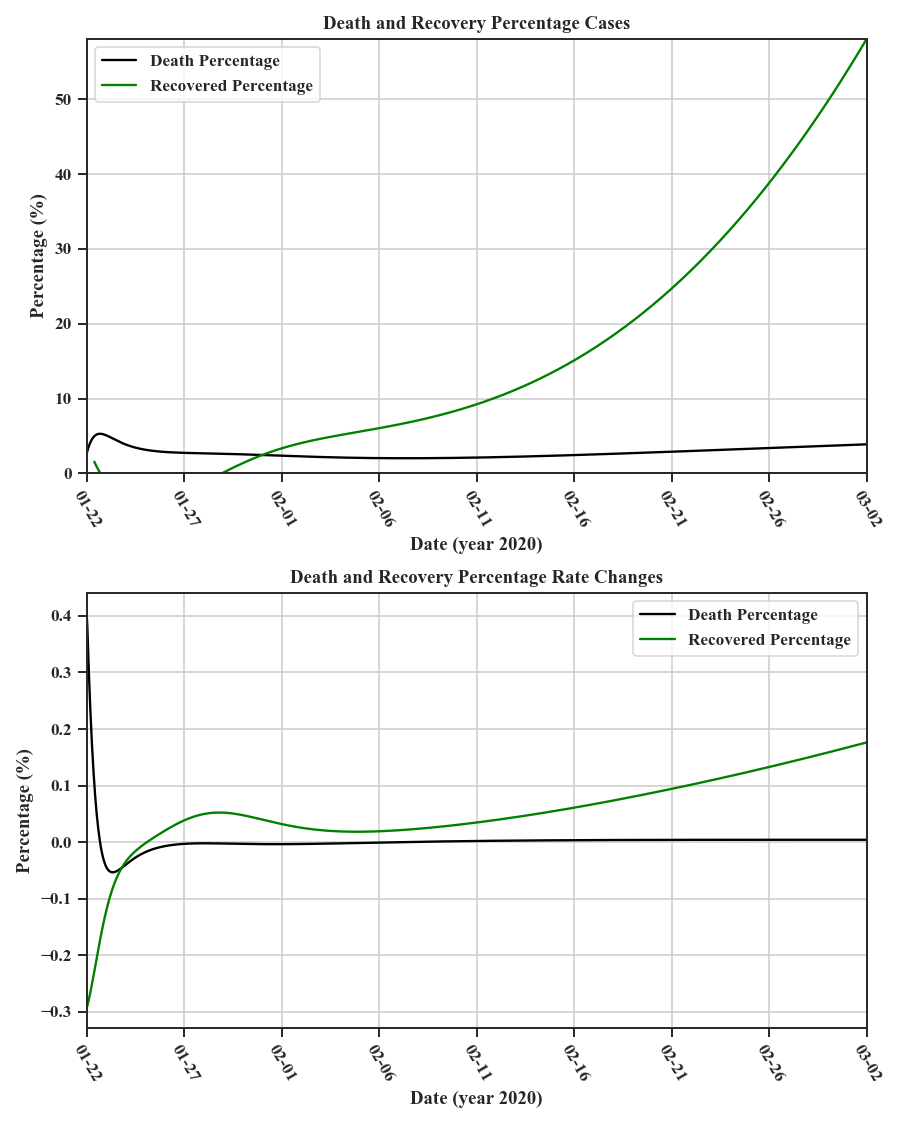

In [27]:
plt.figure(figsize=(8,10))
plt.subplot(211)

plt.plot(x_vals, death_percentage, color ='black',label = 'Death Percentage')
plt.plot(x_vals[10:], recovered_percentage[10:], color = 'green', label = 'Recovered Percentage')

day_spam = 5
plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.ylim(0,np.max([np.max(death_percentage),np.max(recovered_percentage)]))
plt.xlim(0,days)

plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')

plt.subplot(212)

plt.plot(x_vals, np.gradient(death_percentage), color ='black',label = 'Death Percentage')
plt.plot(x_vals, np.gradient(recovered_percentage), color = 'green', label = 'Recovered Percentage')

plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)
plt.xlim(0,days)

plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage Rate Changes')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')

plt.tight_layout()